<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/notebook/Lab04_MLP_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multilayer Perceptrons
- 이번 실습에서는 multilayer perceptron model을 이용하여 classification model을 학습시켜봅니다.
- hidden layer의 개수, hidden unit의 개수, activation function의 종류를 바꾸는 방법을 익힙니다.
- regularization을 위한 방법(weight decay, dropout 등)을 적용하는 방법을 익힙니다.
- training set과 validation set의 accuracy가 epoch에 따라 어떻게 변하는지 관찰하여 모델을 학습시켜 봅니다.

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import os

from torch import nn

## Softmax & Cross-Entropy Loss

In [2]:
y = torch.tensor([[1.,0,0]])
y_hat = torch.tensor([[2,-1.2,3]])

# Softmax
y_hat_softmax = torch.exp(y_hat) / torch.sum(torch.exp(y_hat))
print(y_hat_softmax)

# Cross Entropy Loss
CEloss = -torch.sum(y*torch.log(y_hat_softmax))
print(CEloss)

tensor([[0.2660, 0.0108, 0.7231]])
tensor(1.3242)


In [3]:
y = torch.tensor([[1.,0,0]])
y_hat = torch.tensor([[2,-1.2,3]])

# Softmax
y_hat_softmax = y_hat.softmax(dim=1)
print(y_hat_softmax)

# Cross Entropy Loss
CEloss = nn.CrossEntropyLoss()
print(CEloss(y_hat_softmax, torch.argmax(y, dim=1)))
print(CEloss(y_hat, y))
print(CEloss(y_hat, torch.argmax(y, dim=1)))

tensor([[0.2660, 0.0108, 0.7231]])
tensor(1.2102)
tensor(1.3242)
tensor(1.3242)


### ECG데이터 가져오기

In [ ]:
dpath = 'training2017'
d = pd.read_csv(os.path.join(dpath,'REFERENCE.csv'),header=None)
d[:3]

,0,1
0,A00001,N
1,A00002,N
2,A00003,N


In [ ]:
Nlist = d[d[1]=='N']
Alist = d[d[1]=='A']
len(Nlist),len(Alist)

(5050, 738)

In [ ]:
Ntr = 512
Nvd = 128
Nlist_vd = Nlist[-Nvd:]
Alist_vd = Alist[-Nvd:]
Nlist = Nlist[:Ntr]
Alist = Alist[:Ntr]

In [ ]:
def data_iter(batch_size, dpath, Nlist, Alist, L):
    num_examplesN = len(Nlist)
    num_examplesA = len(Alist)
    indicesN = list(range(num_examplesN))
    indicesA = list(range(num_examplesA))
    # The examples are read at random, in no particular order
    random.shuffle(indicesN)
    batch_size2 = int(batch_size/2)
    for i in range(0, num_examplesN, batch_size):
        batch_indicesN = indicesN[i:min(i+batch_size2, num_examplesN)]
        random.shuffle(indicesA)
        features = torch.zeros((batch_size,L))
        labels = torch.zeros((batch_size,))
        for bi in range(0, len(batch_indicesN)):
            sign = sio.loadmat(os.path.join(dpath,Nlist.iloc[batch_indicesN[bi],0]+'.mat'))
            siga = sio.loadmat(os.path.join(dpath,Alist.iloc[indicesA[bi],0]+'.mat'))
            sign = sign['val']
            siga = siga['val']
            r1 = random.randint(0,len(sign[0,:])-L)
            r2 = random.randint(0,len(siga[0,:])-L)
            features[2*bi,:] = torch.tensor(sign[0,r1:r1+L])
            features[2*bi+1,:] = torch.tensor(siga[0,r2:r2+L])
            labels[2*bi] = 0
            labels[2*bi+1] = 1

        yield 0.001*features, labels

torch.Size([2, 1024])
torch.Size([2])


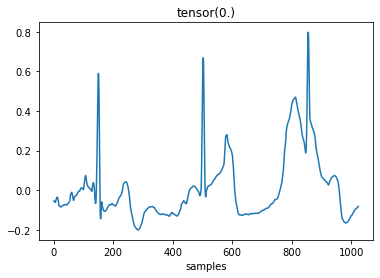

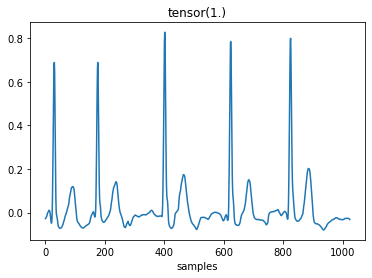

In [ ]:
L = 1024
i = 0
for X_tr, y_tr in data_iter(2,dpath,Nlist,Alist,L):
    print(X_tr.shape)
    print(y_tr.shape)
    i=i+1
    for n in range(2):
        plt.plot(X_tr[n])
        plt.title(y_tr[n])
        plt.xlabel('samples')
        plt.show()
    break

### Hyperparameter설정

In [ ]:
L = 1024
batch_size = 32
lr = 0.02
num_epochs = 1000

### Model, loss function, algorithm

In [ ]:
net = nn.Sequential(nn.Linear(L, L*2),nn.Dropout(p=0),nn.ReLU(),nn.Linear(L*2,2))
loss = nn.CrossEntropyLoss(reduction='mean')
alg = torch.optim.SGD(net.parameters(),lr, weight_decay=0)

### Model 학습

epoch #0,train loss: 0.599474310874939
accuracy of train set: 70.703125 %
accuracy of valid set: 67.1875 %
epoch #100,train loss: 0.5633742809295654
accuracy of train set: 73.2421875 %
accuracy of valid set: 62.5 %
epoch #200,train loss: 0.5711380243301392
accuracy of train set: 71.09375 %
accuracy of valid set: 69.53125 %
epoch #300,train loss: 0.5867341756820679
accuracy of train set: 69.7265625 %
accuracy of valid set: 61.71875 %
epoch #400,train loss: 0.5872047543525696
accuracy of train set: 69.921875 %
accuracy of valid set: 64.0625 %
epoch #500,train loss: 0.5752052068710327
accuracy of train set: 71.484375 %
accuracy of valid set: 66.40625 %
epoch #600,train loss: 0.61738121509552
accuracy of train set: 68.359375 %
accuracy of valid set: 71.875 %
epoch #700,train loss: 0.5955648422241211
accuracy of train set: 69.53125 %
accuracy of valid set: 64.0625 %
epoch #800,train loss: 0.5493109226226807
accuracy of train set: 73.046875 %
accuracy of valid set: 66.40625 %
epoch #900,trai

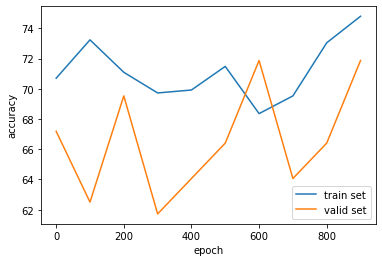

In [ ]:
epoch_tr_accuracy = []
epoch_vd_accuracy = []
eval_interval = 100
for epoch in range(num_epochs):
    l_train = []
    i = 0
    Ncorrect=0
    N=0
    for X_tr, y_tr in data_iter(batch_size,dpath,Nlist,Alist,L):
        y_tr_pred = net(X_tr)
        l = loss(y_tr_pred, y_tr.type(torch.LongTensor))
        l_train.append(l.sum().detach().numpy())
        l.backward()
        alg.step()
        alg.zero_grad()
        Ncorrect += torch.sum(y_tr==torch.argmax(y_tr_pred.softmax(1),dim=1)).numpy()
        N += len(X_tr)
        i=i+1
    if epoch%eval_interval==0:
        print(f'epoch #{epoch},train loss: {np.sum(l_train)/i}')
        tr_accuracy = 100*Ncorrect/(N)
        print(f'accuracy of train set: {tr_accuracy} %')

#        print(f'weights: {net[0].weight[0][:4]}, ...')
        for X_vd, y_vd in data_iter(Nvd,dpath,Nlist_vd,Alist_vd,L):
            y_vd_pred = net(X_vd)
            vd_accuracy = 100*torch.sum(y_vd==torch.argmax(y_vd_pred.softmax(1),dim=1))/Nvd
            print(f'accuracy of valid set: {vd_accuracy} %')
        epoch_tr_accuracy.append(tr_accuracy)
        epoch_vd_accuracy.append(vd_accuracy)

x = np.arange(0,num_epochs,eval_interval)
plt.plot(x,epoch_tr_accuracy)
plt.plot(x,epoch_vd_accuracy)
plt.legend(['train set','valid set'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

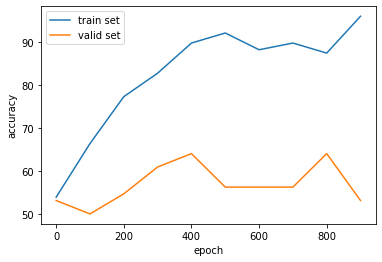

In [ ]:
plt.plot(x,epoch_tr_accuracy)
plt.plot(x,epoch_vd_accuracy)
plt.legend(['train set','valid set'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
net = nn.Sequential(nn.Linear(L, L*2),nn.Dropout(p=0.25),nn.ReLU(),nn.Linear(L*2,2))
loss = nn.CrossEntropyLoss(reduction='mean')
alg = torch.optim.SGD(net.parameters(),lr, weight_decay=0.01)

In [ ]:
epoch_tr_accuracy = []
epoch_vd_accuracy = []
eval_interval = 100
for epoch in range(num_epochs):
    l_train = []
    i = 0
    Ncorrect=0
    N=0
    for X_tr, y_tr in data_iter(batch_size,dpath,Nlist,Alist,L):
        y_tr_pred = net(X_tr)
        l = loss(y_tr_pred, y_tr.type(torch.LongTensor))
        l_train.append(l.sum().detach().numpy())
        l.backward()
        alg.step()
        alg.zero_grad()
        Ncorrect += torch.sum(y_tr==torch.argmax(y_tr_pred.softmax(1),dim=1)).numpy()
        N += len(X_tr)
        i=i+1
    if epoch%eval_interval==0:
        print(f'epoch #{epoch},train loss: {np.sum(l_train)/i}')
        tr_accuracy = 100*Ncorrect/(N)
        print(f'accuracy of train set: {tr_accuracy} %')

#        print(f'weights: {net[0].weight[0][:4]}, ...')
        for X_vd, y_vd in data_iter(Nvd,dpath,Nlist_vd,Alist_vd,L):
            y_vd_pred = net(X_vd)
            vd_accuracy = 100*torch.sum(y_vd==torch.argmax(y_vd_pred.softmax(1),dim=1))/Nvd
            print(f'accuracy of valid set: {vd_accuracy} %')
        epoch_tr_accuracy.append(tr_accuracy)
        epoch_vd_accuracy.append(vd_accuracy)

x = np.arange(0,num_epochs,eval_interval)
plt.plot(x,epoch_tr_accuracy)
plt.plot(x,epoch_vd_accuracy)
plt.legend(['train set','valid set'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()